# Agent, RL and MultiEnvironment

It is recommended to have a look at the [0_basic_functionalities](0_basic_functionalities.ipynb), [1_Observation_Agents](1_Observation_Agents.ipynb) and [2_Action_GridManipulation](2_Action_GridManipulation.ipynb) and especially [3_TrainingAnAgent](3_TrainingAnAgent.ipynb) notebooks before getting into this one.

**Objectives**

In this notebook we will expose :
* what is a "MultiEnv"
* how can it be used with an agent
* how can it be used to train a agent that uses different environments

In [1]:
res = None
try:
    from jyquickhelper import add_notebook_menu
    res = add_notebook_menu()
except ModuleNotFoundError:
    print("Impossible to automatically add a menu / table of content to this notebook.\nYou can download \"jyquickhelper\" package with: \n\"pip install jyquickhelper\"")
res

In [2]:
import grid2op
from grid2op.Reward import ConstantReward, FlatReward
import sys
import os
import numpy as np
TRAINING_STEP = 10

## I) Download more data for the default environment.

A lot of data have been made available for the default "case14_redisp" environment. Including this data in the package is not convenient. We chose instead to release them and make them easily available with a utility. To download them in the default directory ("~/data_grid2op/case14_redisp") on linux based system you can do the following (uncomment the following command)

In [3]:
# !$sys.executable -m grid2op.download --name "case14_realistic"

## II) Make a regular environment and agent

Now that we downloaded the dataset, it is time to make an environment that will use all the data avaiable. You can execute the following command line. If you see any error or warning consider re downloading the data, or adapting the key-word argument "chronics_path" to match the path where the data have been downloaded.

In [4]:
try:
    env = grid2op.make(name_env="case14_realistic",
                       chronics_path=os.path.expanduser("~/data_grid2op/case14_realistic"))
except Exception as exc :
    print("Please read the above cell, it appears you don't have downloaded the dataset, "\
          "or save it into an unknown repository. " \
          "I will continue with only 2 sets.")
    env = grid2op.make(name_env="case14_realistic")

Please read the above cell, it appears you don't have downloaded the dataset, or save it into an unknown repository. I will continue with only 2 sets.


/home/donnotben/Documents/Grid2Op_dev/getting_started/grid2op/MakeEnv.py:667: UserWarning:

Your are using only 2 chronics for this environment. More can be download by running, from a command line:
python -m grid2op.download --name "case14_realistic" --path_save PATH\WHERE\YOU\WANT\TO\DOWNLOAD\DATA



## III) Train a standard RL Agent

Make sure you are using a computer with at least 4 cores if you want to notice some speed-ups.

In [5]:
from grid2op.Environment import MultiEnvironment
from grid2op.Agent import DoNothingAgent
NUM_CORE = 8

### IIIa) Using the standard open AI gym loop

Here we demonstrate how to use the multi environment class. First let's create a multi environment.

In [6]:
# create a simple agent
agent = DoNothingAgent(env.action_space)

# create the multi environment class
multi_envs = MultiEnvironment(env=env, nb_env=NUM_CORE)

A multienvironment is just like a regular environment but instead of dealing with one action, and one observation, is requires to be sent multiple actions, and returns a list of observations as well. 

It requires a grid2op environment to be initialized and creates some specific "workers", each a replication of the initial environment. None of the "worker" can be accessed directly. Supported methods are:
- multi_env.reset
- multi_env.step
- multi_env.close

That have similar behaviour to "env.step", "env.close" or "env.reset".


It can be used the following manner.

In [7]:
# initiliaze some variable with the proper dimension
obss = multi_envs.reset()
rews = [env.reward_range[0] for i in range(NUM_CORE)]
dones = [False for i in range(NUM_CORE)]
obss

array([<grid2op.Observation.CompleteObservation.CompleteObservation object at 0x7f269e06b710>,
      dtype=object)

In [8]:
dones

[False, False, False, False, False, False, False, False]

As you can see, obs is not a single obervation, but a list (numpy nd array to be precise) of 4 observations, each one being an observation of a given "worker" environment.

Worker environments are always called in the same order. It means the first observation of this vector will always correspond to the first worker environment. 


Similarly to Observation, the "step" function of a multi_environment takes as input a list of multiple actions, each action will be implemented in its own environment. It returns a list of observations, a list of rewards, and boolean list of whether or not the worker environment suffer from a game over (in that case this worker environment is automatically restarted using the "reset" method.)

Because orker environments are always called in the same order, the first action sent to the "multi_env.step" function will also be applied on this first environment.

It is possible to use it as follow:

In [9]:
# initialize the vector of actions that will be processed by each worker environment.
acts = [None for _ in range(NUM_CORE)]
for env_act_id in range(NUM_CORE):
    acts[env_act_id] = agent.act(obss[env_act_id], rews[env_act_id], dones[env_act_id])
    
# feed them to the multi_env
obss, rews, dones, infos = multi_envs.step(acts)

# as explained, this is a vector of Observation (as many as NUM_CORE in this example)
obss

array([<grid2op.Observation.CompleteObservation.CompleteObservation object at 0x7f26e511a8d0>,
      dtype=object)

The multi environment loop is really close to the "gym" loop:

In [10]:
# performs the appropriated steps
for i in range(TRAINING_STEP):
    acts = [None for _ in range(NUM_CORE)]
    for env_act_id in range(NUM_CORE):
        acts[env_act_id] = agent.act(obss[env_act_id], rews[env_act_id], dones[env_act_id])
    obss, rews, dones, infos = multi_envs.step(acts)

    # DO SOMETHING WITH THE AGENT IF YOU WANT
    ## agent.train(obss, rews, dones)
    

# close the environments created by the multi_env
multi_envs.close()

On the above example, `TRAINING_STEP` steps are performed on `NUM_CORE` environments in parrallel. The agent has then acted `TRAINING_STEP * NUM_CORE` (=`10 * 4 = 40` by default) times on `NUM_CORE` different environments.

### III.b) Practical example

We reuse the code of the Notebook [3_TrainingAnAgent](3_TrainingAnAgent.ipynb) to train a new agent, but this time using more than one process of the machine. To further emphasize the working of multi environments, we put on a different module ([ml_agent](ml_agent.py)) the code of some agents and focus here on the training part. 

Note that compare to the previous notebook, the code have been adapted to used "batch" of data when predicting movments. The input data is also restricted to:
- the relative flow value
- the powerline status
- the topology vector

All the other component of the observations are not used.

In [11]:
from ml_agent import TrainingParam, ReplayBuffer, DeepQAgent
from grid2op.Agent import AgentWithConverter
from grid2op.Reward import RedispReward
from grid2op.Converter import IdToAct
import numpy as np
import random
import warnings
import pdb
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=FutureWarning)
    import tensorflow.keras
    import tensorflow.keras.backend as K
    from tensorflow.keras.models import load_model, Sequential, Model
    from tensorflow.keras.optimizers import Adam
    from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, subtract, add
    from tensorflow.keras.layers import Input, Lambda, Concatenate

In [12]:
class TrainAgentMultiEnv(object):
    def __init__(self, agent, nb_process, reward_fun=RedispReward, env=None, name=None):
        # compare to the version showed in the notebook 3, the process buffer has been moved in this class
        # and we add a multi_envs argument.
        self.nb_process = nb_process
        self.multi_envs = None
        self.process_buffer = [[] for _ in range(self.nb_process)]
        self.name = name
        self.agent = agent
        self.env = env
        self.training_param = None
    
    def convert_process_buffer(self):
        """Converts the list of NUM_FRAMES images in the process buffer
        into one training sample"""
        # here i simply concatenate the action in case of multiple action in the "buffer"
        if self.training_param.NUM_FRAMES != 1:
            raise RuntimeError("This has not been tested with self.training_param.NUM_FRAMES != 1 for now")
        return np.array([np.concatenate(el) for el in self.process_buffer])
        
    def _build_valid_env(self, training_param):
        # this function has also be adapted
        create_new = False
        if self.multi_envs is None:
            create_new = True
            # first we need to initialize the multi environment
            self.multi_envs = MultiEnvironment(env=env, nb_env=self.nb_process)
            
            # then, as before, we reset it
            obss = self.multi_envs.reset()
            for worker_id in range(self.nb_process):
                self.process_buffer[worker_id].append(self.agent.convert_obs(obss[worker_id]))
                
            # used in case of "num frames" != 1 (so not tested)
            do_nothing = [self.env.action_space() for _ in range(self.nb_process)]
            for _ in range(training_param.NUM_FRAMES-1):
                # Initialize buffer with the first frames
                s1, r1, _, _ = self.multi_envs.step(do_nothing)
                for worker_id in range(self.nb_process):
                    # difference compared to previous implementation: we loop through all the observations
                    # and save them all
                    self.process_buffer[worker_id].append(self.agent.convert_obs(s1[worker_id])) 
                    
        return create_new
    
    def train(self, num_frames, training_param=TrainingParam()):
        self.training_param = training_param
        
        # first we create an environment or make sure the given environment is valid
        close_env = self._build_valid_env(training_param)
        
        # same as in the original implemenation, except the process buffer is now in this class
        observation_num = 0
        curr_state = self.convert_process_buffer()
        
        # we initialize the NN exactly as before
        self.agent.init_deep_q(curr_state)
            
        # some parameters have been move to a class named "training_param" for convenience
        epsilon = training_param.INITIAL_EPSILON
        # now the number of alive frames and total reward depends on the "underlying environment". It is vector instead
        # of scalar
        alive_frame = np.zeros(self.nb_process, dtype=np.int)
        total_reward = np.zeros(self.nb_process, dtype=np.float)

        while observation_num < num_frames:
            if observation_num % 1000 == 999:
                print(("Executing loop %d" %observation_num))
                # for efficient reading of data: at early stage of training, it is advised to load
                # data by chunk: the model will do game over pretty easily (no need to load all the dataset)
                tmp = min(10000 * (num_frames // observation_num), 10000)
                self.multi_envs.set_chunk_size(int(max(100, tmp)))

            # Slowly decay the learning rate
            if epsilon > training_param.FINAL_EPSILON:
                epsilon -= (training_param.INITIAL_EPSILON-training_param.FINAL_EPSILON)/training_param.EPSILON_DECAY

            initial_state = self.convert_process_buffer()
            self.process_buffer = [[] for _ in range(self.nb_process)]
            
            # TODO vectorize that in the Agent directly
            # then we need to predict the next moves. Agents have been adapted to predict a batch of data
            pm_i, pq_v = self.agent.deep_q.predict_movement(curr_state, epsilon)
            # and build the convenient vectors (it was scalars before)
            predict_movement_int = []
            predict_q_value = []
            acts = []
            for p_id in range(self.nb_process):
                predict_movement_int.append(pm_i[p_id])
                predict_q_value.append(pq_v[p_id])
                # and then we convert it to a valid action
                acts.append(self.agent.convert_act(pm_i[p_id]))
            
            # same loop as in notebook 3
            reward, done = np.zeros(self.nb_process), np.full(self.nb_process, fill_value=False, dtype=np.bool)
            for i in range(training_param.NUM_FRAMES):
                temp_observation_obj, temp_reward, temp_done, _ = self.multi_envs.step(acts)
                
                # we need to handle vectors for "done"
                reward[~temp_done] += temp_reward[~temp_done]
                # and then "de stack" the observations coming from different environments
                for worker_id, obs in enumerate(temp_observation_obj):
                    self.process_buffer[worker_id].append(self.agent.convert_obs(temp_observation_obj[worker_id])) 
                done = done | temp_done
                
                # increase of 1 the number of frame alive for relevant "underlying environments"
                alive_frame[~temp_done] += 1
                # loop through the environment where a game over was done, and print the results
                for env_done_idx in np.where(temp_done)[0]:
                    print("For env with id {}".format(env_done_idx))
                    print("\tLived with maximum time ", alive_frame[env_done_idx])
                    print("\tEarned a total of reward equal to ", total_reward[env_done_idx])
                
                reward[temp_done] = 0.
                total_reward[temp_done] = 0.
                total_reward += reward
                alive_frame[temp_done] = 0
            
            # vectorized version of the previous code
            new_state = self.convert_process_buffer()
            # same as before, but looping through the "underlying environment"
            for sub_env_id in range(self.nb_process):
                self.agent.replay_buffer.add(initial_state[sub_env_id],
                                             predict_movement_int[sub_env_id],
                                             reward[sub_env_id],
                                             done[sub_env_id],
                                             new_state[sub_env_id])
                
            if self.agent.replay_buffer.size() > training_param.MIN_OBSERVATION:
                s_batch, a_batch, r_batch, d_batch, s2_batch = self.agent.replay_buffer.sample(training_param.MINIBATCH_SIZE)
                isfinite = self.agent.deep_q.train(s_batch, a_batch, r_batch, d_batch, s2_batch, observation_num)
                self.agent.deep_q.target_train()
            
                if not isfinite:
                    # if the loss is not finite i stop the learning
                    print("ERROR INFINITE LOSS")
                    break
                

            # Save the network every 10000 iterations
            if observation_num % 10000 == 9999 or observation_num == num_frames-1:
                print("Saving Network")
                if self.name is None:
                    self.agent.deep_q.save_network("saved_notebook6.h5")
                else:
                    self.agent.deep_q.save_network("saved_notebook6_{}".format(self.name))
                
            observation_num += 1
            
        if close_env:
            print("closing env")
            self.env.close()
        

We redifine the class used to train the agent.

In [13]:
agent_name = "sac_1e5"
try:
    env = grid2op.make("case14_realistic",
                       chronics_path = os.path.expanduser("~/data_grid2op/case14_realistic")
                      )
except:
    env = grid2op.make("case14_realistic")
my_agent = DeepQAgent(env.action_space, mode="SAC", training_param=TrainingParam())
trainer = TrainAgentMultiEnv(agent=my_agent, env=env, nb_process=NUM_CORE, name=agent_name)
# trainer = TrainAgent(agent=my_agent, env=env)
trainer.train(TRAINING_STEP)

/home/donnotben/Documents/Grid2Op_dev/getting_started/grid2op/MakeEnv.py:667: UserWarning:

Your are using only 2 chronics for this environment. More can be download by running, from a command line:
python -m grid2op.download --name "case14_realistic" --path_save PATH\WHERE\YOU\WANT\TO\DOWNLOAD\DATA



Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Successfully constructed networks.
For env with id 1
	Lived with maximum time  0
	Earned a total of reward equal to  0.0
For env with id 2
	Lived with maximum time  2
	Earned a total of reward equal to  2173.7099096977045
For env with id 4
	Lived with maximum time  2
	Earned a total of reward equal to  2173.7099096977045
For env with id 6
	Lived with maximum time  2
	Earned a total of reward equal to  2173.7099096977045
For env with id 0
	Lived with maximum time  3
	Earned a total of reward equal to  3262.123313523708
Instructions for updating:
Use tf.cast instead.
For env with id 2
	Lived with maximum time  6
	Earned a total of reward equal to  6586.890989316329
Saving Network
Successfully saved network.
closing env


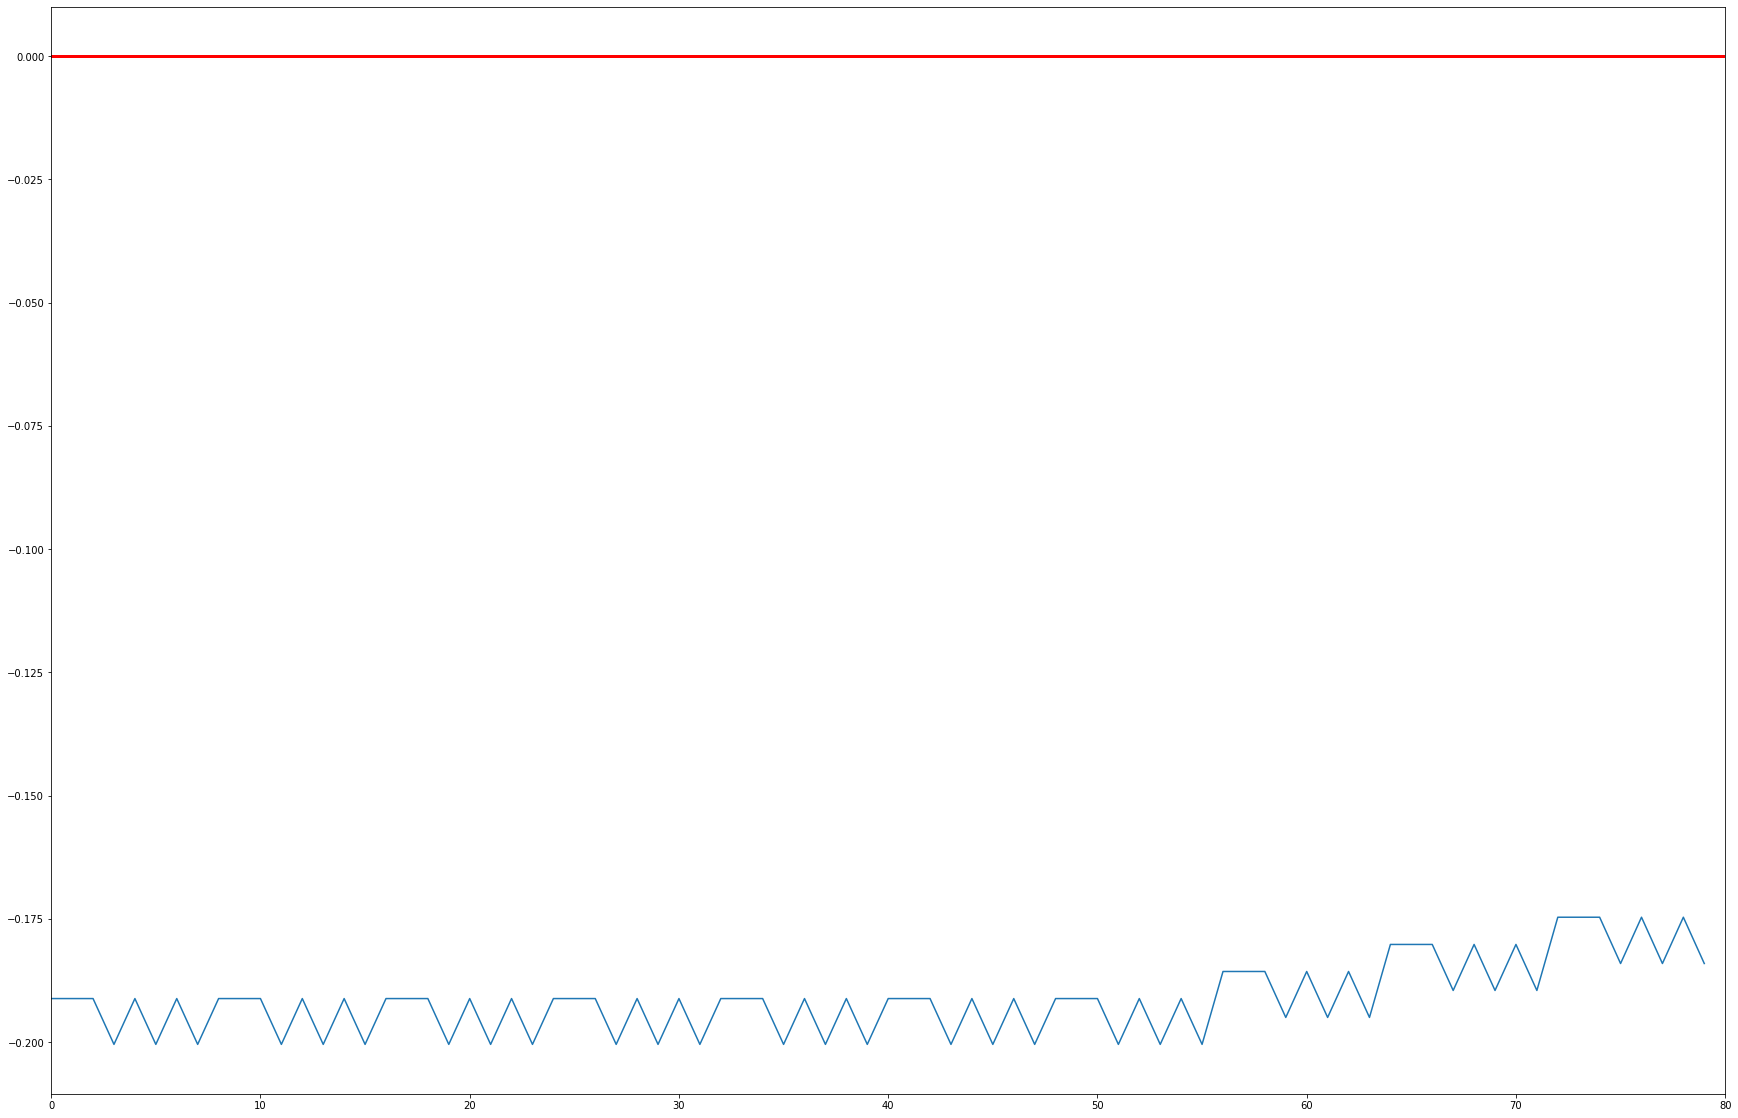

In [14]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(30,20))
plt.plot(my_agent.deep_q.qvalue_evolution)
plt.axhline(y=0, linewidth=3, color='red')
_ = plt.xlim(0, len(my_agent.deep_q.qvalue_evolution))

A loss trained for 100000 iterations on 8 cores, for a ddqn agent and default parameters can look like:
![](img/qvalue.png)

### III c) Assess the performance of the trained agent

First we evaluate the performance of a baseline, in this case the "do nothing" agent.

**NB** The use of a Runner (see the first notebook) is particurlaly suited for that purpose. We are showing here how to quickly assess the performances.

In [15]:
from tqdm.notebook import tqdm
NB_EPISODE = 2
nrow = 100  # 12*24*7*4*NB_EPISODE
# tun the do nothing for the whole episode
dn_agent = grid2op.Agent.DoNothingAgent(env.action_space)

reward = env.reward_range[0]
env.set_id(0)
i = 0
with tqdm(total=nrow, desc="do nothing") as pbar:
    for _ in range(NB_EPISODE):
        obs = env.reset()
        done= False
        while not done:
            act = dn_agent.act(obs, reward, done)
            obs, reward, done, info = env.step(act)
            i += 1
            pbar.update(1)
            if i >= nrow-1:
                break
print("Time last by Do Nothing: {}".format(i))


Time last by Do Nothing: 100


Then we load the saved neural network, and we can now evaluate the fixed policy:

In [16]:
obs = env.reset()
trained_agent = DeepQAgent(env.action_space, mode="DDQN", training_param=TrainingParam())
trained_agent.init_deep_q(trained_agent.convert_obs(obs))
trained_agent.load_network("saved_notebook6_{}".format(agent_name))

reward = env.reward_range[0]
env.set_id(0)
i = 0
with tqdm(total=nrow, desc="trained agent") as pbar:
    for _ in range(NB_EPISODE):
        obs = env.reset()
        done= False
        while not done:
            act = trained_agent.act(obs, reward, done)
            obs, reward, done, info = env.step(act)
            i += 1
            pbar.update(1)
            if i >= nrow-1:
                break
print("Time last by the trained agent: {}".format(i))

Successfully constructed networks.
Succesfully loaded network.



Time last by the trained agent: 100


A default DDQN agent trained on 8 cores on 1000000 steps (so 8e6 steps in total), 24h of training on a laptop achieved to perform 5637 steps, largely outperforming the "do nothing" agent (which did only 2180 steps on the same 2 environment).